In [ ]:
from google.colab import drive

# This will display the contents of your Google Drive's root directory if mounted,
# otherwise, it will throw an error.
try:
    drive.mount('/content/drive')
    print("Google Drive is mounted.")
except:
    print("Google Drive is not mounted.")


Mounted at /content/drive
Google Drive is mounted.


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
import os

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
IMAGE_WIDTH = 508
IMAGE_HEIGHT = 287
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 200
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10



checkpoint_dir = r"/content/drive/My Drive/GAN - Data Projekt/"

dataroot = "/content/drive/My Drive/GAN - Data Projekt/Billeder(Trimmet)/Billeder (gode)"  # dental radiography data/Good"

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
                               transforms.Grayscale(num_output_channels=1),  # Converts RGB to greyscale
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))  # Use a single value for mean and std
                           ]))

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)


device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
# Check GPU information
print("GPU Information:")
!nvidia-smi

# Check CPU information
print("\nCPU Information:")
!lscpu

GPU Information:
Mon May 20 12:16:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              52W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+--------

In [ ]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    #print(BATCH_SIZE, C, H, W)
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    #print(f"Real shape: {real.shape}, Fake shape: {fake.shape}")
    interpolated_images = real * alpha + fake * (1 - alpha)


    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])


In [ ]:


# Define the Generator class as previously defined
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Initial input is Z: (channels_noise x 1 x 1)
            nn.ConvTranspose2d(channels_noise, features_g * 16, 4, 1, 0, bias=False),  # output: (features_g * 16) x 4 x 4
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 16, features_g * 8, 4, 2, 1, bias=False),  # output: (features_g * 8) x 8 x 8
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),  # output: (features_g * 4) x 16 x 16
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),  # output: (features_g * 2) x 32 x 32
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),  # output: (features_g) x 64 x 64
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, features_g // 2, 4, 2, 1, bias=False),  # output: (features_g // 2) x 128 x 128
            nn.BatchNorm2d(features_g // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g // 2, features_g // 4, 4, 2, 1, bias=False),  # output: (features_g // 4) x 256 x 256
            nn.BatchNorm2d(features_g // 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g // 4, features_g // 8, (4, 2), (1, 2), (1, 1), bias=False),  # output: (features_g // 8) x 256 x 512
            nn.BatchNorm2d(features_g // 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g // 8, channels_img, (33, 1), (1, 1), (1, 1), bias=False),  # Fine-tune to exact 288 x 512
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

#

In [ ]:

class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False),  # 64 x 144 x 256
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d, features_d * 2, 4, 2, 1, bias=False),  # 128 x 72 x 128
            nn.InstanceNorm2d(features_d * 2, affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1, bias=False),  # 256 x 36 x 64
            nn.InstanceNorm2d(features_d * 4, affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1, bias=False),  # 512 x 18 x 32
            nn.InstanceNorm2d(features_d * 8, affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 8, features_d * 16, 4, 2, 1, bias=False),  # 1024 x 9 x 16
            nn.InstanceNorm2d(features_d * 16, affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 16, features_d * 32, 4, 2, 1, bias=False),  # 2048 x 4 x 8
            nn.InstanceNorm2d(features_d * 32, affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d * 32, 1, (4, 7), (1, 1), 0, bias=False),  # 1 x 1 x 1

        )

    def forward(self, x):
        return self.model(x).view(x.size(0), -1)


In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)




In [ ]:
# Initialize the generator and critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# Initialize the optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# Initialize TensorBoard writer
writer_real = SummaryWriter()
writer_fake = SummaryWriter()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=runs

<IPython.core.display.Javascript object>

In [ ]:
gen.train()
critic.train()


# Training loop
for epoch in range(NUM_EPOCHS):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Generate fake images
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        # Train Critic
        for _ in range(CRITIC_ITERATIONS):
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Log the losses to TensorBoard
        if batch_idx % 10 == 0:
            writer_real.add_scalar("Critic Loss", loss_critic.item(), global_step=epoch * len(loader) + batch_idx)
            writer_fake.add_scalar("Generator Loss", loss_gen.item(), global_step=epoch * len(loader) + batch_idx)

            with torch.no_grad():
                fake = gen(noise).detach().cpu()
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real Images", img_grid_real, global_step=epoch * len(loader) + batch_idx)
                writer_fake.add_image("Fake Images", img_grid_fake, global_step=epoch * len(loader) + batch_idx)

        # Update the progress bar
        loop.set_postfix(loss_critic=loss_critic.item(), loss_gen=loss_gen.item())

    print(f"Completed Epoch {epoch+1}/{NUM_EPOCHS}.")  # Confirms the completion of the current epoch

    # Save the model checkpoint after 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint = {
            "epoch": epoch,
            "gen_state_dict": gen.state_dict(),
            "critic_state_dict": critic.state_dict(),
            "gen_optimizer": opt_gen.state_dict(),
            "critic_optimizer": opt_critic.state_dict(),
        }
        save_checkpoint(checkpoint, filename=os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth"))

    elif epoch == 0:
        checkpoint = {
            "epoch": epoch,
            "gen_state_dict": gen.state_dict(),
            "critic_state_dict": critic.state_dict(),
            "gen_optimizer": opt_gen.state_dict(),
            "critic_optimizer": opt_critic.state_dict(),
        }
        save_checkpoint(checkpoint, filename=os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth"))

# Close the TensorBoard writers
writer_real.close()
writer_fake.close()

  0%|          | 0/19 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/19 [03:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 276.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 254.81 MiB is free. Process 9399 has 39.31 GiB memory in use. Of the allocated memory 38.26 GiB is allocated by PyTorch, and 555.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            nn.ConvTranspose2d(in_channels=channels_noise, out_channels=features_g * 64, kernel_size=4, stride=1, padding=0, bias=False),  # img: 4x4
            nn.BatchNorm2d(num_features=features_g * 64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=features_g * 64, out_channels=features_g * 32, kernel_size=4, stride=2, padding=1, bias=False),  # img: 8x8
            nn.BatchNorm2d(num_features=features_g * 32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=features_g * 32, out_channels=features_g * 16, kernel_size=4, stride=2, padding=1, bias=False),  # img: 16x16
            nn.BatchNorm2d(num_features=features_g * 16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=features_g * 16, out_channels=features_g * 8, kernel_size=4, stride=2, padding=1, bias=False),  # img: 32x32
            nn.BatchNorm2d(num_features=features_g * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=features_g * 8, out_channels=features_g * 4, kernel_size=4, stride=2, padding=1, bias=False),  # img: 64x64
            nn.BatchNorm2d(num_features=features_g * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=features_g * 4, out_channels=features_g * 2, kernel_size=4, stride=2, padding=1, bias=False),  # img: 128x128
            nn.BatchNorm2d(num_features=features_g * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=features_g * 2, out_channels=features_g, kernel_size=4, stride=2, padding=1, bias=False),  # img: 256x256
            nn.BatchNorm2d(num_features=features_g),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=features_g, out_channels=channels_img, kernel_size=4, stride=2, padding=1, bias=False),  # img: 512x512
            nn.Tanh(),  # Output: N x channels_img x 512 x 512
        )

    def forward(self, x):
        return self.net(x)


In [ ]:

model_path = "/content/drive/My Drive/GAN - Data Projekt/checkpoint_epoch_400.pth"


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Define the path to the .pth file
#model_path = "/content/drive/My Drive/GAN - Data Projekt/checkpoint_epoch_250_512x521.pth"

# Initialize the model with the same parameters used during training
channels_noise = 100  # Example value, set this to your actual value
channels_img = 1      # Assuming the image has 1 channel based on the error message
features_g = 64       # Example value, set this to your actual value

# Initialize the model
print("Initialize the model")
model = Generator(channels_noise, channels_img, features_g)

# Load the entire checkpoint
print("Load the entire checkpoint")
checkpoint = torch.load(model_path)

# Extract the generator's state dictionary
print("Extract the generator's state dictionary")
state_dict = checkpoint['gen_state_dict']

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model.eval()  # Set the model to evaluation mode


Initialize the model
Load the entire checkpoint
Extract the generator's state dictionary


Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 4096, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

## Epoch 250

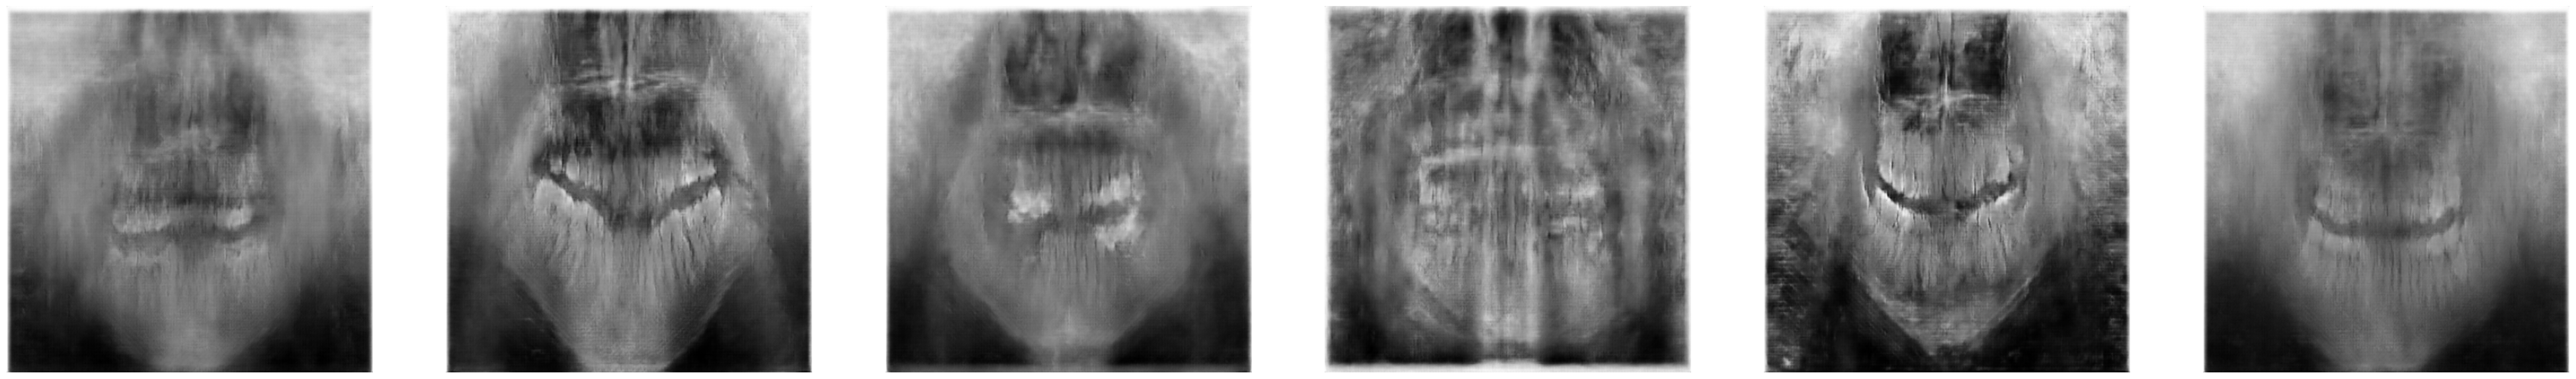

In [ ]:
import matplotlib.pyplot as plt

# Define the number of images to generate
num_images = 6

# Generate random noise tensors
noise = torch.randn(num_images, channels_noise, 1, 1)

# Generate images using the model
with torch.no_grad():
    fake_images = model(noise).detach().cpu()

# Convert the tensors to NumPy arrays and unnormalize
fake_images = (fake_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

# Set up the subplot grid
fig, axes = plt.subplots(1, num_images, figsize=(50, 15))

for i in range(num_images):
    # Convert each tensor to a NumPy array
    fake_image = fake_images[i].permute(1, 2, 0).numpy()

    # Display each image
    axes[i].imshow(fake_image, cmap='gray' if channels_img == 1 else None)
    axes[i].axis('off')

plt.show()


## Epoch 400

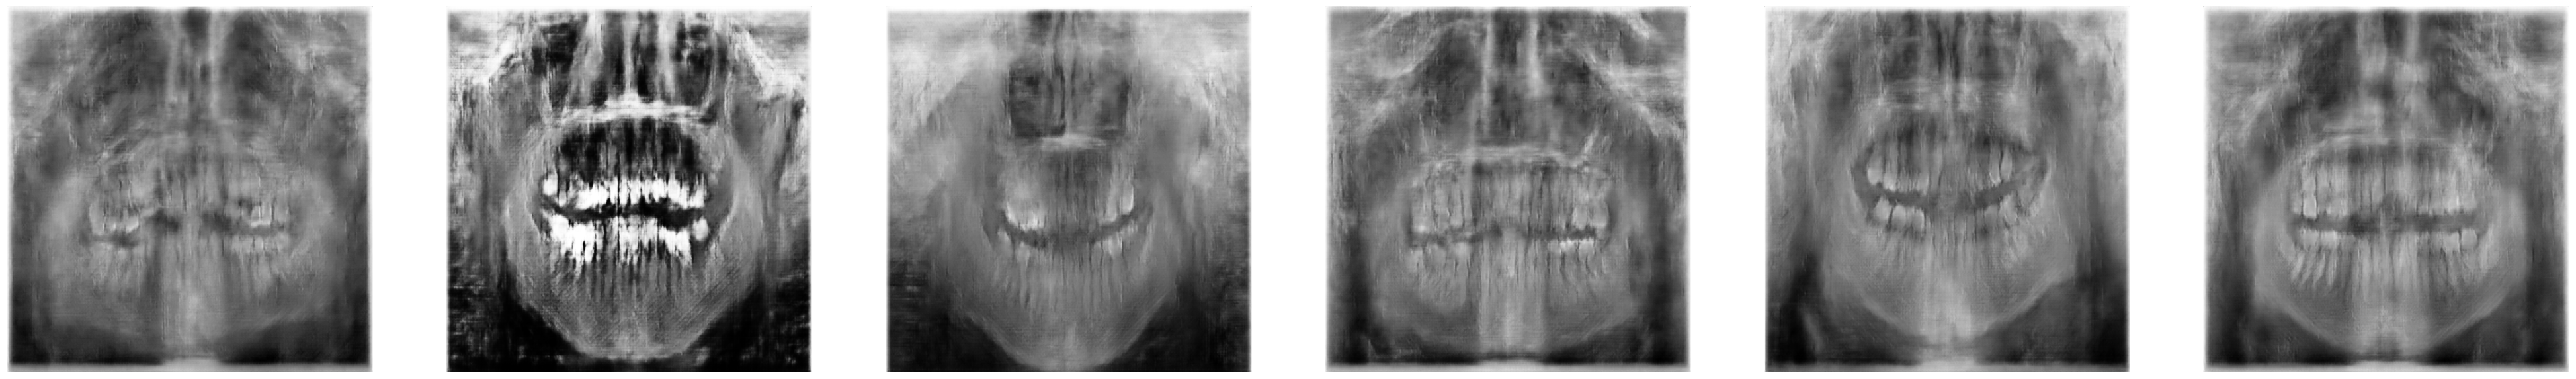

In [ ]:
import matplotlib.pyplot as plt

# Define the number of images to generate
num_images = 6

# Generate random noise tensors
noise = torch.randn(num_images, channels_noise, 1, 1)

# Generate images using the model
with torch.no_grad():
    fake_images = model(noise).detach().cpu()

# Convert the tensors to NumPy arrays and unnormalize
fake_images = (fake_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

# Set up the subplot grid
fig, axes = plt.subplots(1, num_images, figsize=(50, 15))

for i in range(num_images):
    # Convert each tensor to a NumPy array
    fake_image = fake_images[i].permute(1, 2, 0).numpy()

    # Display each image
    axes[i].imshow(fake_image, cmap='gray' if channels_img == 1 else None)
    axes[i].axis('off')

plt.show()
